In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random

### functions

In [35]:
def plot_event_count(evts, n_bins=1_000):
    print(f'{evts.shape[0]:,} events')
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,4))#, dpi=200)
    fig.suptitle(f'event count over time')
    up_data = np.histogram(evts[evts['p'] == 1]['t'], bins=n_bins)
    down_data = np.histogram(evts[evts['p'] == 0]['t'], bins=n_bins)
    ax.bar(up_data[1][:-1], up_data[0], width=up_data[1][1]-up_data[1][0])
    ax.bar(down_data[1][:-1], -1*down_data[0], width=down_data[1][1]-down_data[1][0])
    plt.grid()
    plt.tight_layout()

Histogram stuffs

In [36]:
def histogram_n_events(data, comp:bool, dt, max_x=10_000, n_bins=1_000, 
                       text_xy=(6_000,30), yscale='linear'):
    # basic setup
    data_folder = f'../data/{data}_{dt}ms{"_comp" if comp else ""}'
    MIN_EVTS = 1_000
    ncols = 4
    nrows = 2 if data == 'bin' else 4
    chars = list("ABCD")[:nrows]
    # set up figure with title
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(17,6), dpi=200)
    fig.suptitle(f'histogram for # of events per {dt}ms, {"compressed" if comp else "raw"} (x_axis cutoff at {max_x})')
    # loop over particles and trials
    removed_per_particle = {ch: 0 for ch in chars}
    total_per_particle = {ch: 0 for ch in chars}
    for i, ch in enumerate(chars):
        for j, fidx in enumerate(range(1, 5)):
            # label columns and rows
            if i == 0:
                axs[i][j].set_title(f'trial {fidx}')
            if j == 0:
                axs[i][j].set_ylabel(f'particle {ch}')
            # load data, get rejected chunks
            try:
                l_evts = np.load(f'{data_folder}/{ch}{fidx}.npy', allow_pickle=True)
            except EOFError:
                print(f'error loading {data_folder}/{ch}{fidx}.npy')
                continue
            reject = [evts.shape[0] for evts in l_evts if evts.shape[0] < MIN_EVTS]
            # store number of chunks removed
            removed_per_particle[ch] += len(reject)
            total_per_particle[ch] += len(l_evts)
            # plot histogram
            axs[i][j].hist([evts.shape[0] for evts in l_evts if evts.shape[0] < max_x], bins=n_bins)
            axs[i][j].set_yscale(yscale)
            # plot the text: % of chunks rejected, # of chunks left in dataset
            ratio_reject = len(reject) / len(l_evts)
            n_over1k = len(l_evts) - len(reject)
            text = f'{ratio_reject:.1%} < 1k\n{n_over1k/1e3:.0f}k bins left'
            axs[i][j].text(*text_xy, text, fontsize=8)
    # print % of chunks removed
    for ch in chars:
        print(f"particle {ch}: removed {removed_per_particle[ch]/1e3:.0f}k "
              f"({removed_per_particle[ch]/total_per_particle[ch]:.1%}), "
              f"left {(total_per_particle[ch] - removed_per_particle[ch])/1e3:.0f}k")
    fig.tight_layout()

Event count samples stuffs

In [37]:
def plot_event_count_ax(ax, evts, n_bins=1_000):
    up_data = np.histogram(evts[evts['p'] == 1]['t'], bins=n_bins)
    down_data = np.histogram(evts[evts['p'] == 0]['t'], bins=n_bins)
    ax.bar(up_data[1][:-1], up_data[0], width=up_data[1][1]-up_data[1][0])
    ax.bar(down_data[1][:-1], -1*down_data[0], width=down_data[1][1]-down_data[1][0])
    ax.grid()

In [38]:
def plot_samples(data, comp:str, dt, fn='A1', nrows=4, ncols=4):
    data_folder = f'../data/{data}_{dt}ms{"_" if len(comp) else ""}{comp}'
    MIN_EVTS = 1_000  # NOTE: hard coded for now
    l_evts = np.load(f'{data_folder}/{fn}.npy', allow_pickle=True)
    l_evtsf = [e for e in l_evts if e.shape[0] > MIN_EVTS]
    print(f'{len(l_evtsf):,} time bins with > 1k events '
        f'({len(l_evtsf)/len(l_evts):.1%} of total: {len(l_evts):,})')

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(17,8), dpi=200)
    fig.suptitle(f'event count over time ({dt}ms bins with > 1k events), {fn} {comp}')
    for axidx, idx in enumerate(random.sample(range(len(l_evtsf)), nrows*ncols)):
        print(f'{l_evtsf[idx].shape[0]:,} events', end='\n' if axidx % ncols == ncols-1 else ', ')
        data = l_evtsf[idx]
        data['t'] -= (data['t'].min() // 1000) * 1000
        plot_event_count_ax(axs[axidx//4][axidx%4], data, n_bins=1_000)
    fig.tight_layout()

## binary data

### binary compressed 10ms

particle A: removed 4k (16.4%), left 21k
particle B: removed 4k (15.2%), left 22k


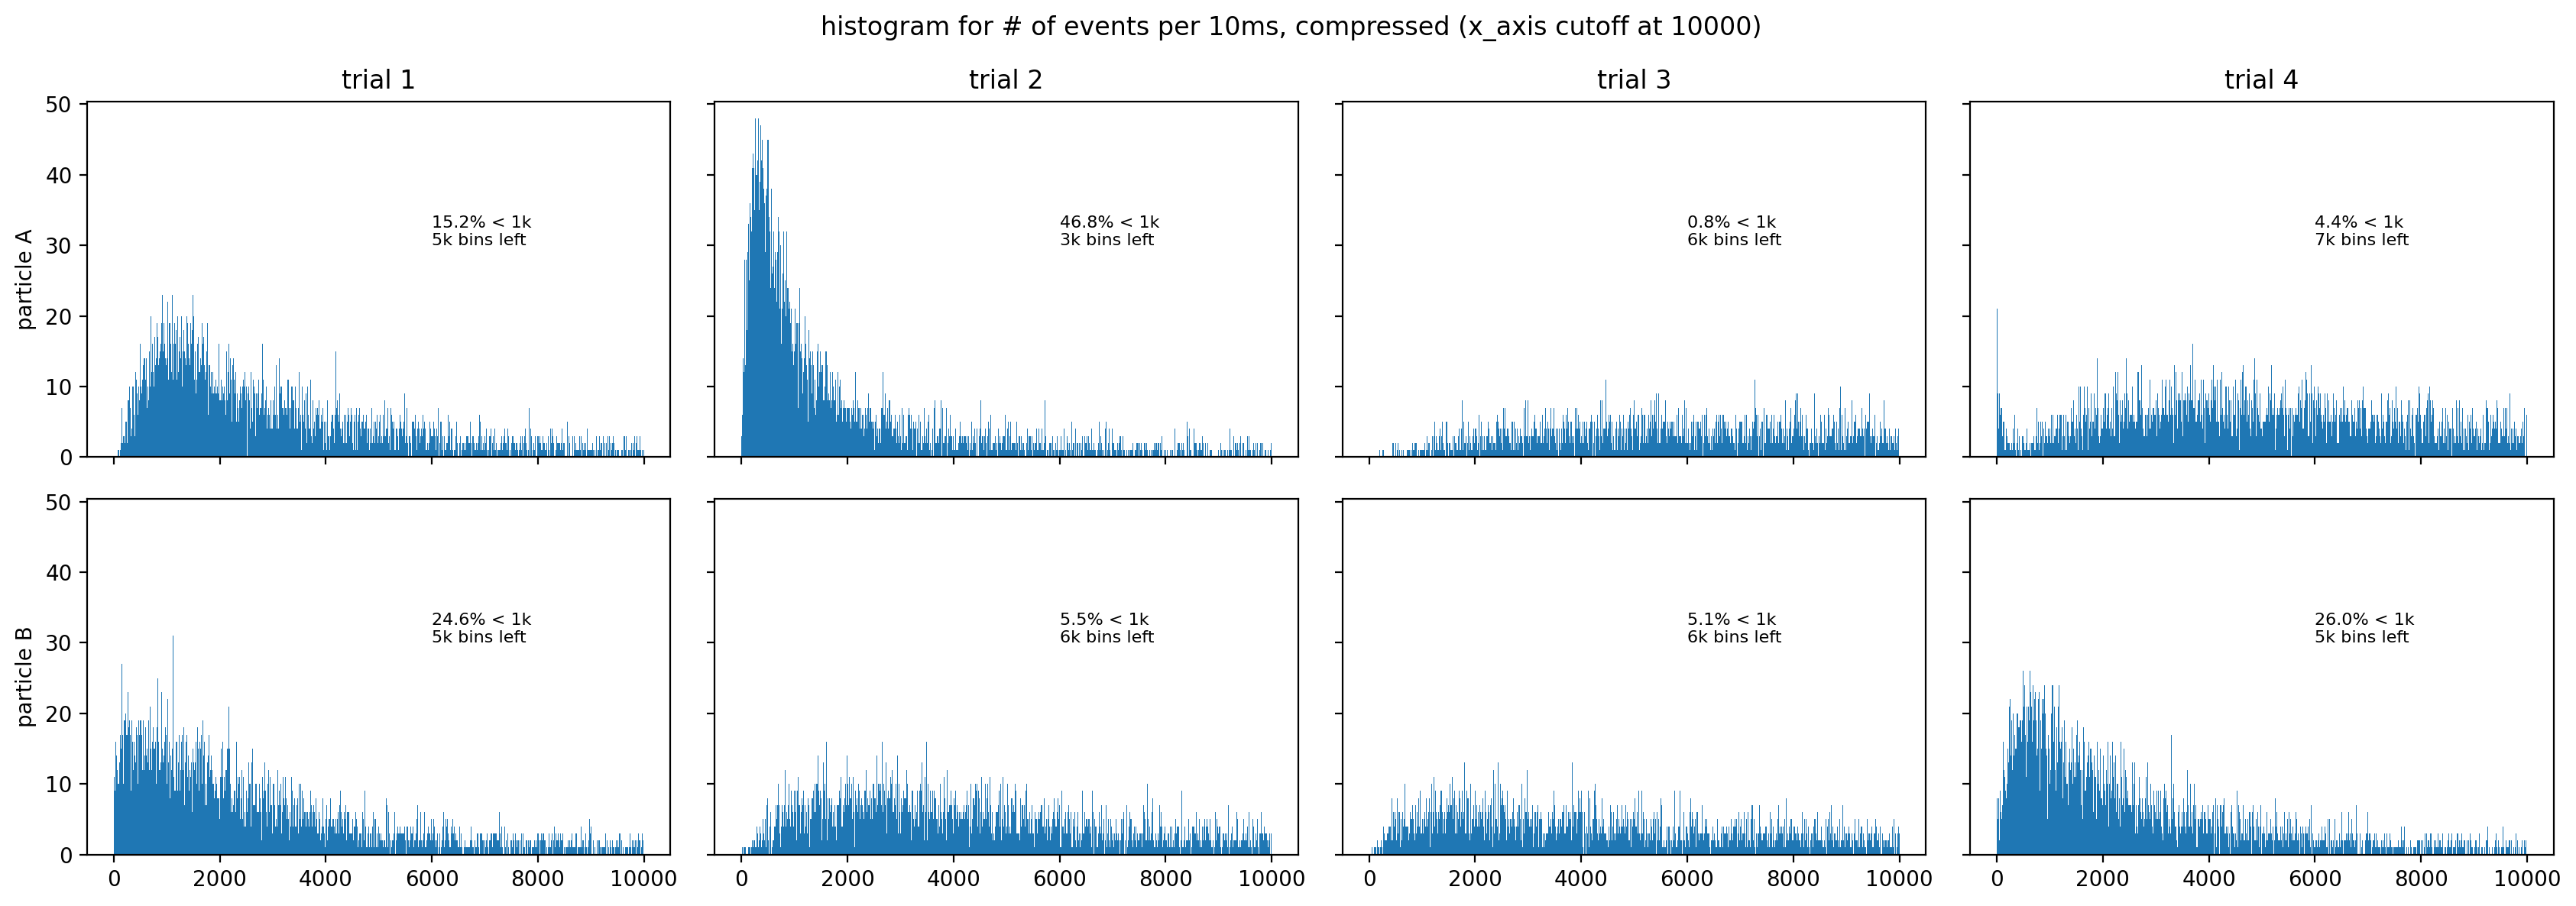

In [39]:
histogram_n_events('bin', True, 10, max_x=10_000, n_bins=1_000, text_xy=(6_000,30))

5,180 time bins with > 1k events (84.8% of total: 6,112)
5,275 events, 1,084 events, 3,680 events, 2,254 events
3,454 events, 2,362 events, 3,623 events, 1,759 events
5,423 events, 3,253 events, 2,169 events, 2,493 events
1,026 events, 4,402 events, 6,665 events, 3,645 events


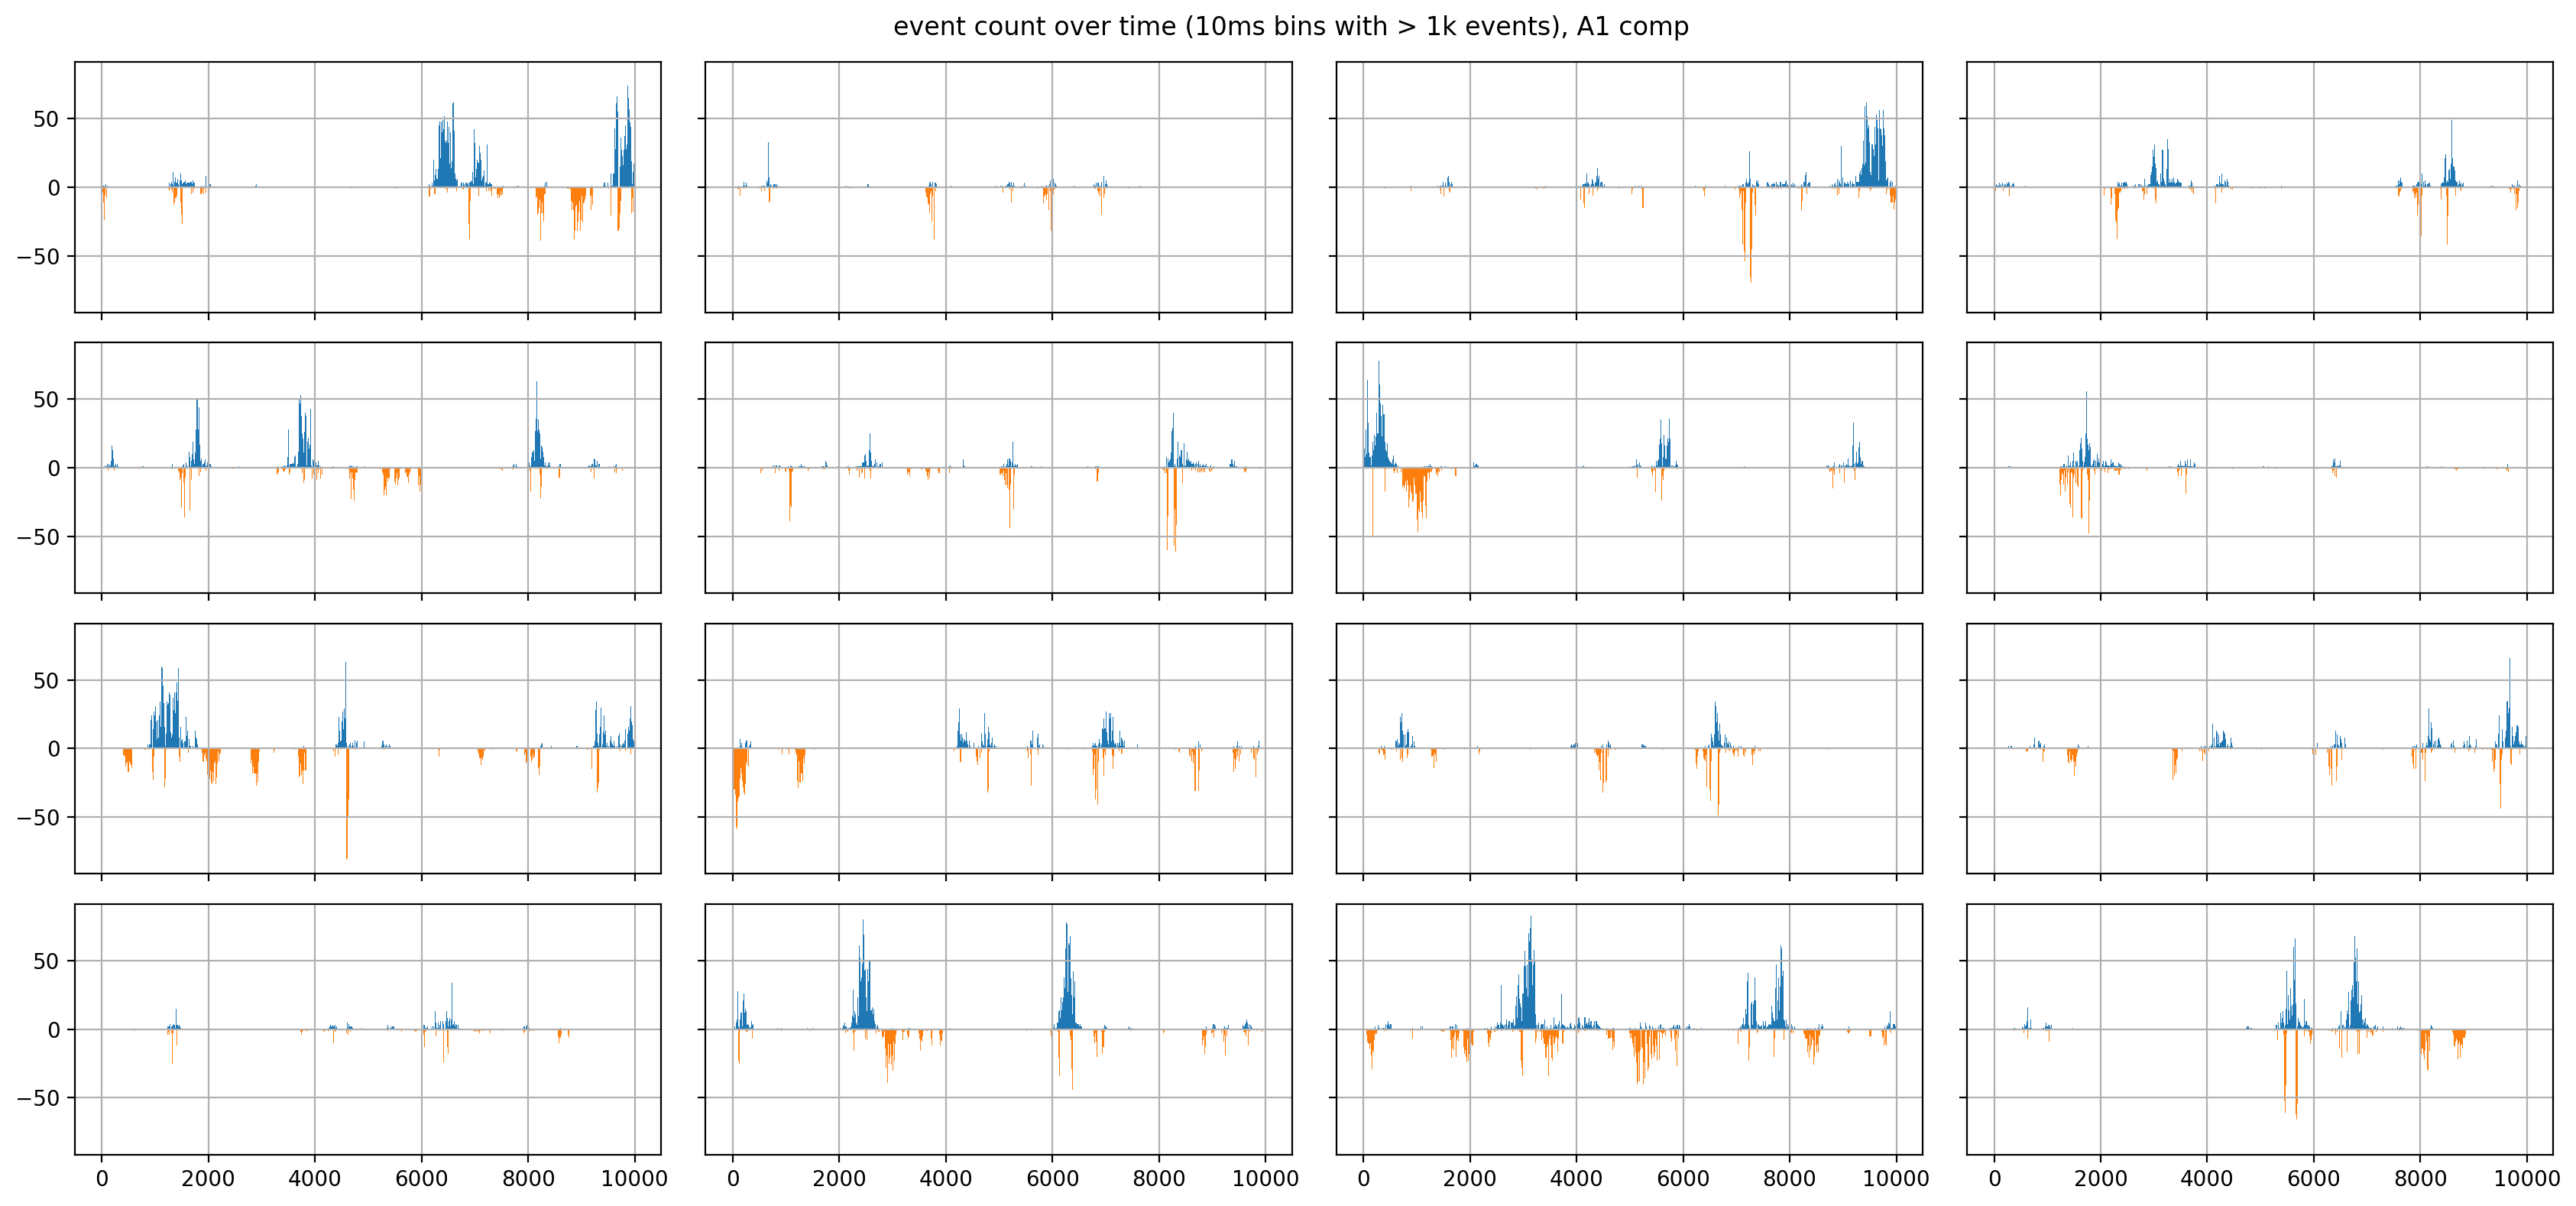

In [40]:
plot_samples('bin', 'comp', 10, fn='A1', nrows=4, ncols=4)

### binary raw 10ms

error loading ../data/bin_10ms/B3.npy
particle A: removed 0k (0.1%), left 26k
particle B: removed 0k (0.0%), left 19k


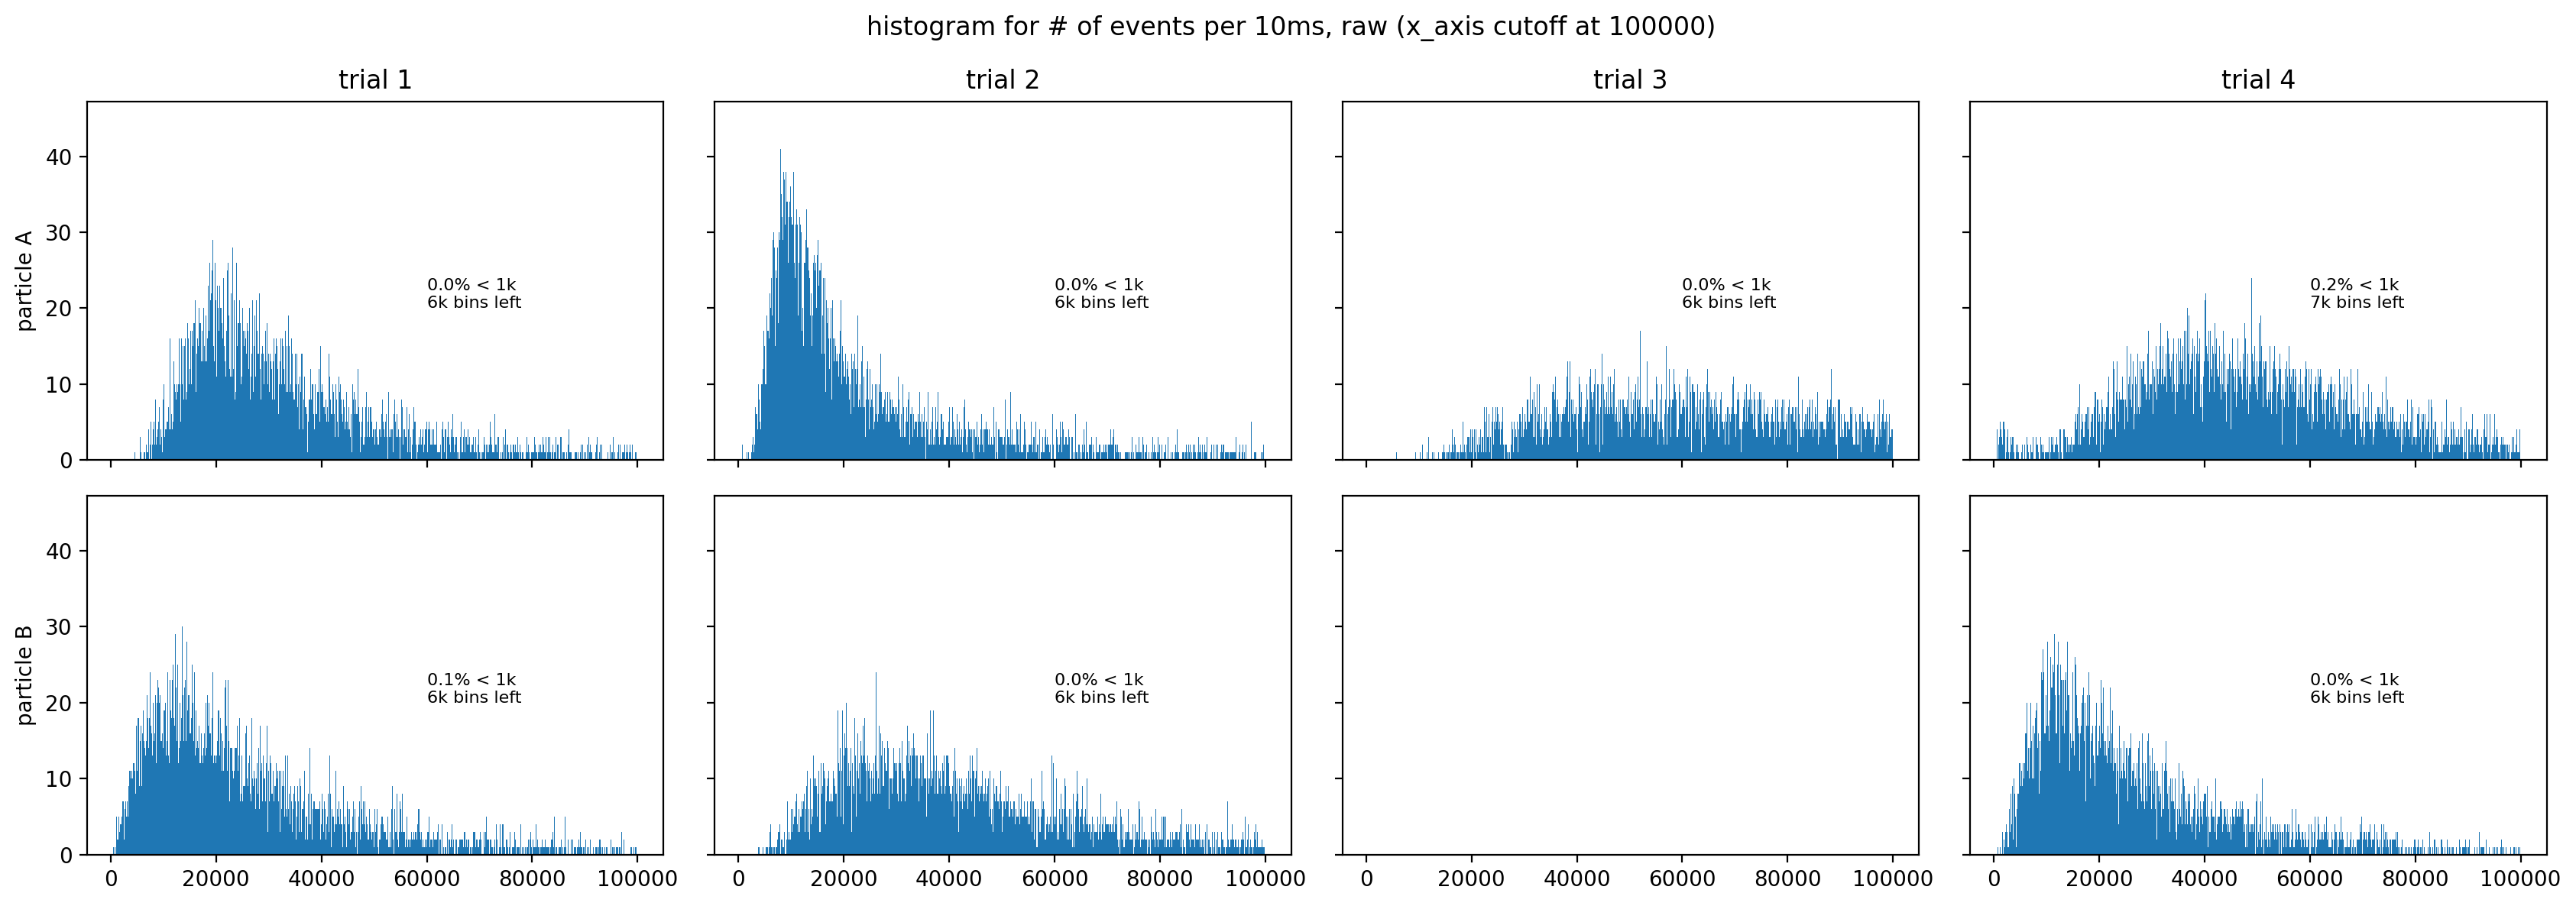

In [41]:
histogram_n_events(data='bin', comp=False, dt=10, max_x=100_000, n_bins=1_000, text_xy=(60000,20))

6,112 time bins with > 1k events (100.0% of total: 6,112)
58,217 events, 14,062 events, 216,414 events, 15,048 events
39,736 events, 31,743 events, 52,415 events, 28,328 events
32,191 events, 38,358 events, 29,146 events, 38,642 events
19,269 events, 18,952 events, 24,432 events, 27,634 events


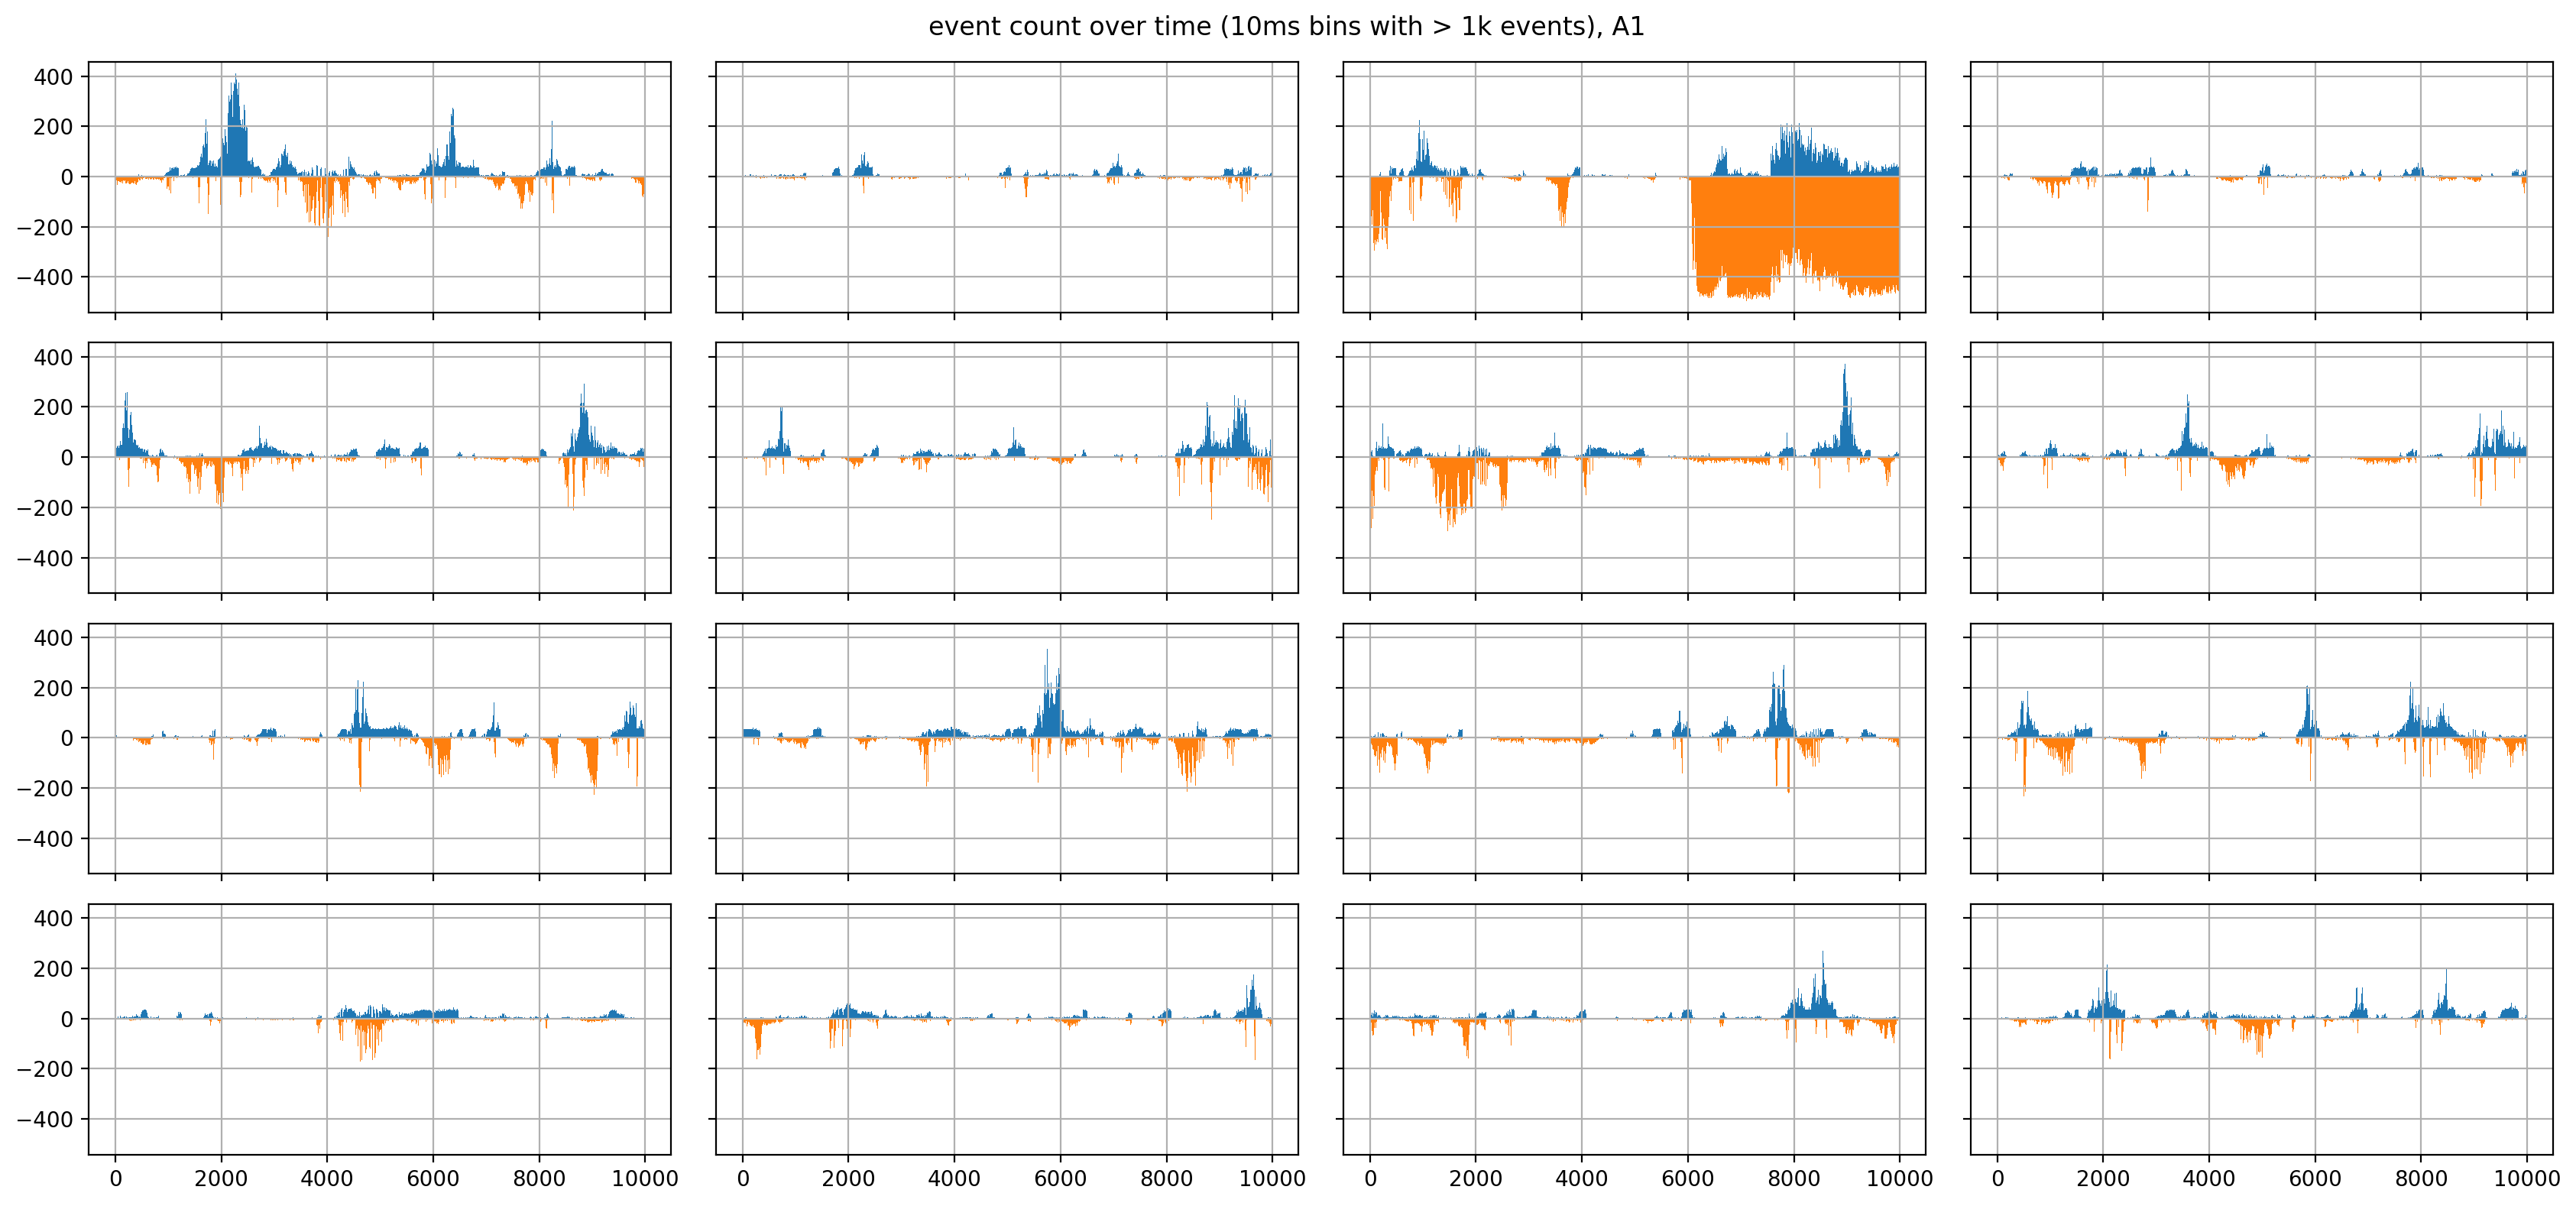

In [42]:
plot_samples('bin', '', 10, fn='A1', nrows=4, ncols=4)

### binary compressed 1ms

particle A: removed 207k (80.7%), left 50k
particle B: removed 209k (82.1%), left 45k


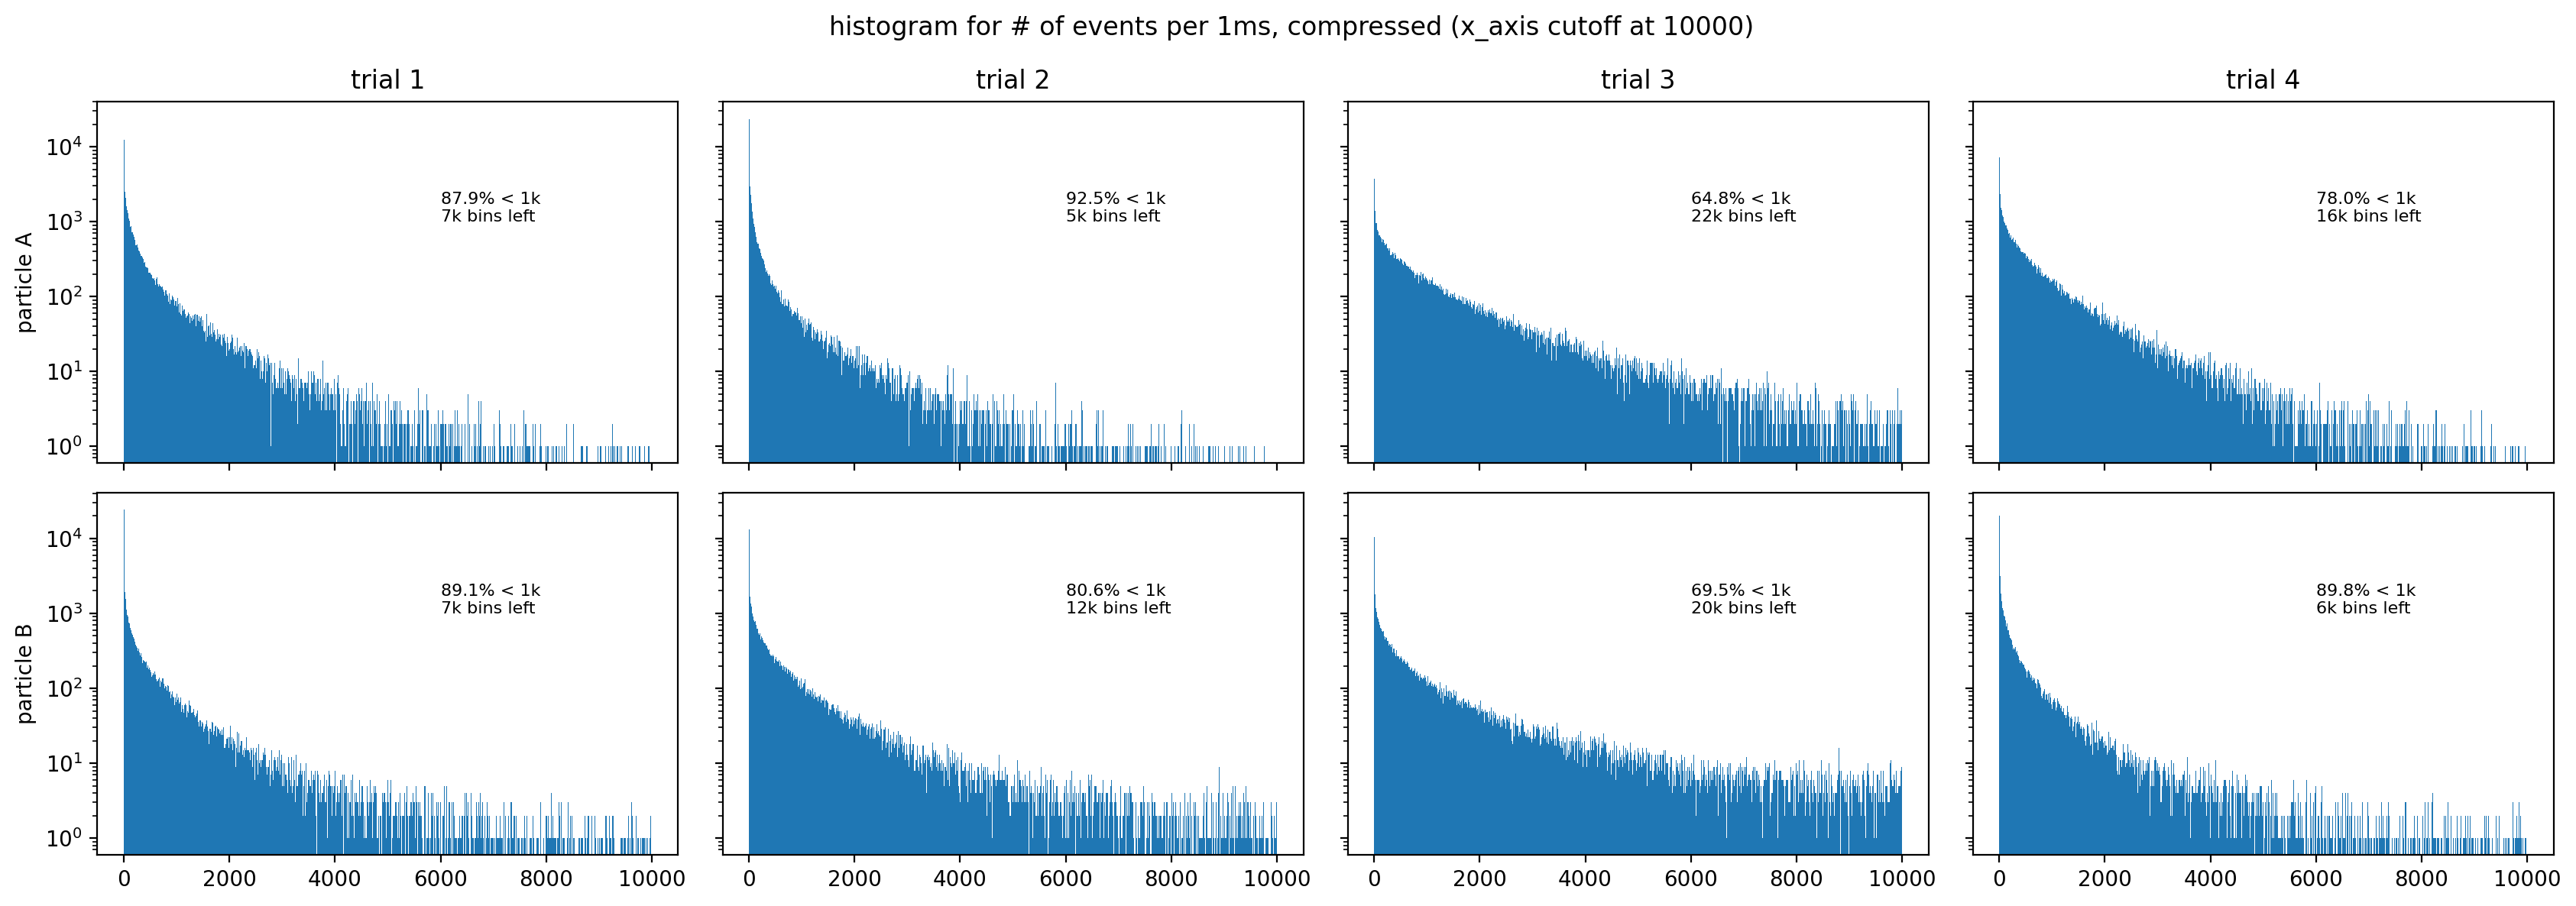

In [43]:
histogram_n_events(data='bin', comp=True, dt=1, max_x=10_000, n_bins=1_000, 
                   text_xy=(6_000,1_000), yscale='log')

7,357 time bins with > 1k events (12.0% of total: 61,120)
8,519 events, 1,175 events, 1,723 events, 5,066 events
1,507 events, 2,524 events, 4,512 events, 4,255 events
3,145 events, 1,307 events, 1,957 events, 1,051 events
4,207 events, 1,326 events, 2,041 events, 1,976 events


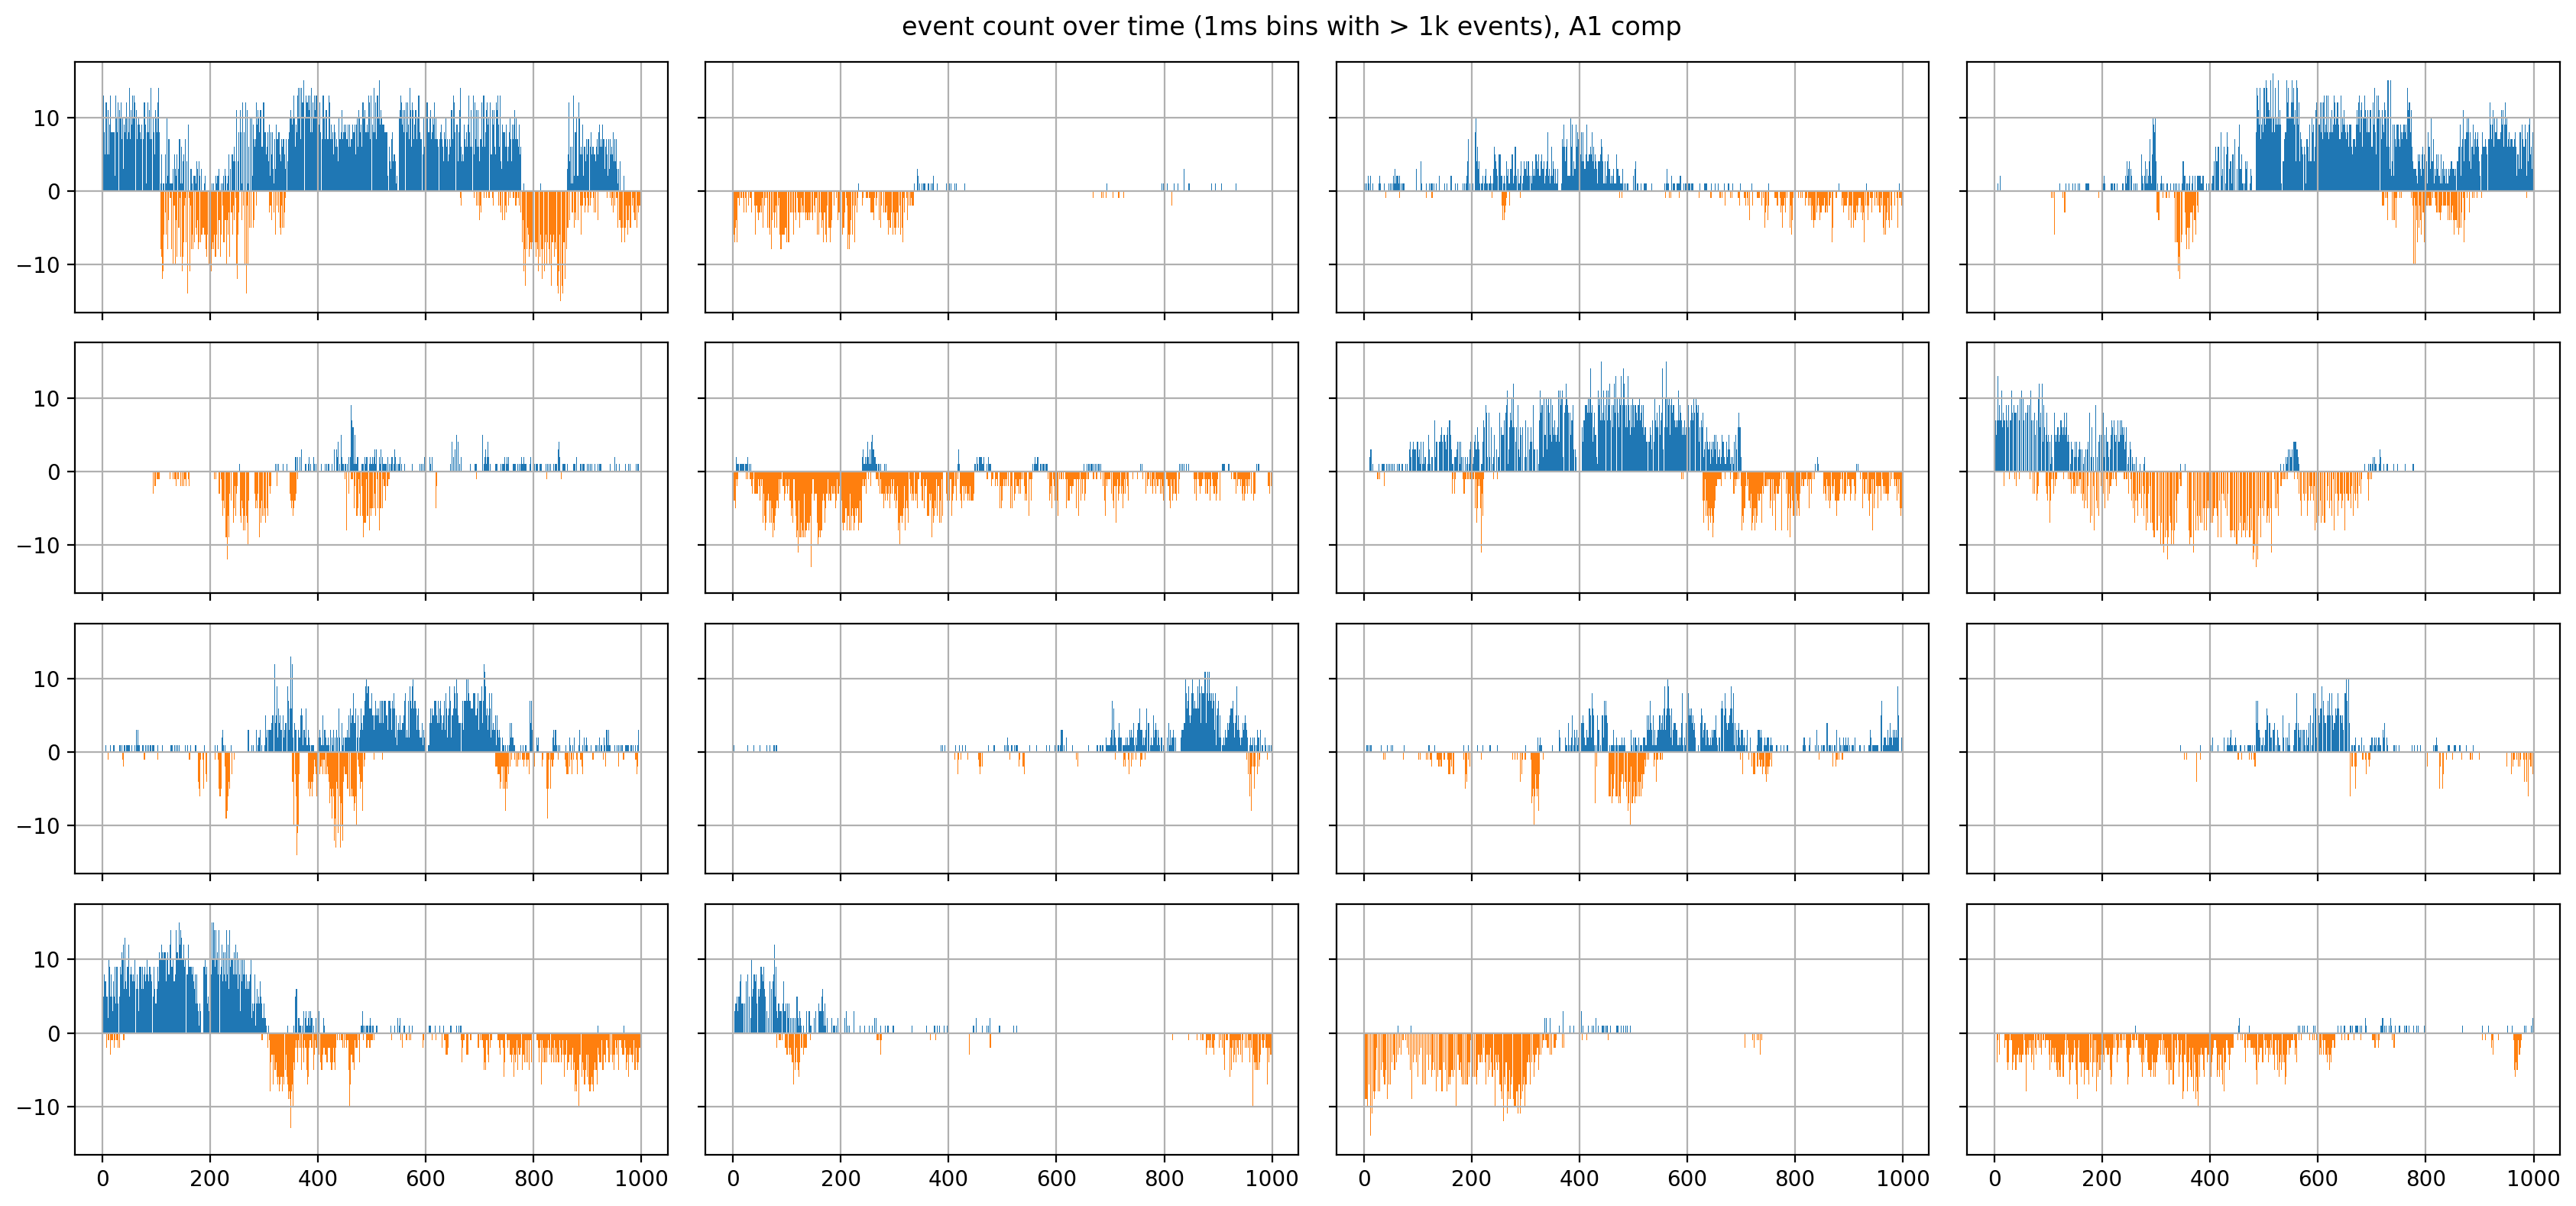

In [44]:
plot_samples('bin', 'comp', 1, fn='A1', nrows=4, ncols=4)

### binary raw 1ms

particle A: removed 51k (19.8%), left 206k
particle B: removed 72k (28.5%), left 182k


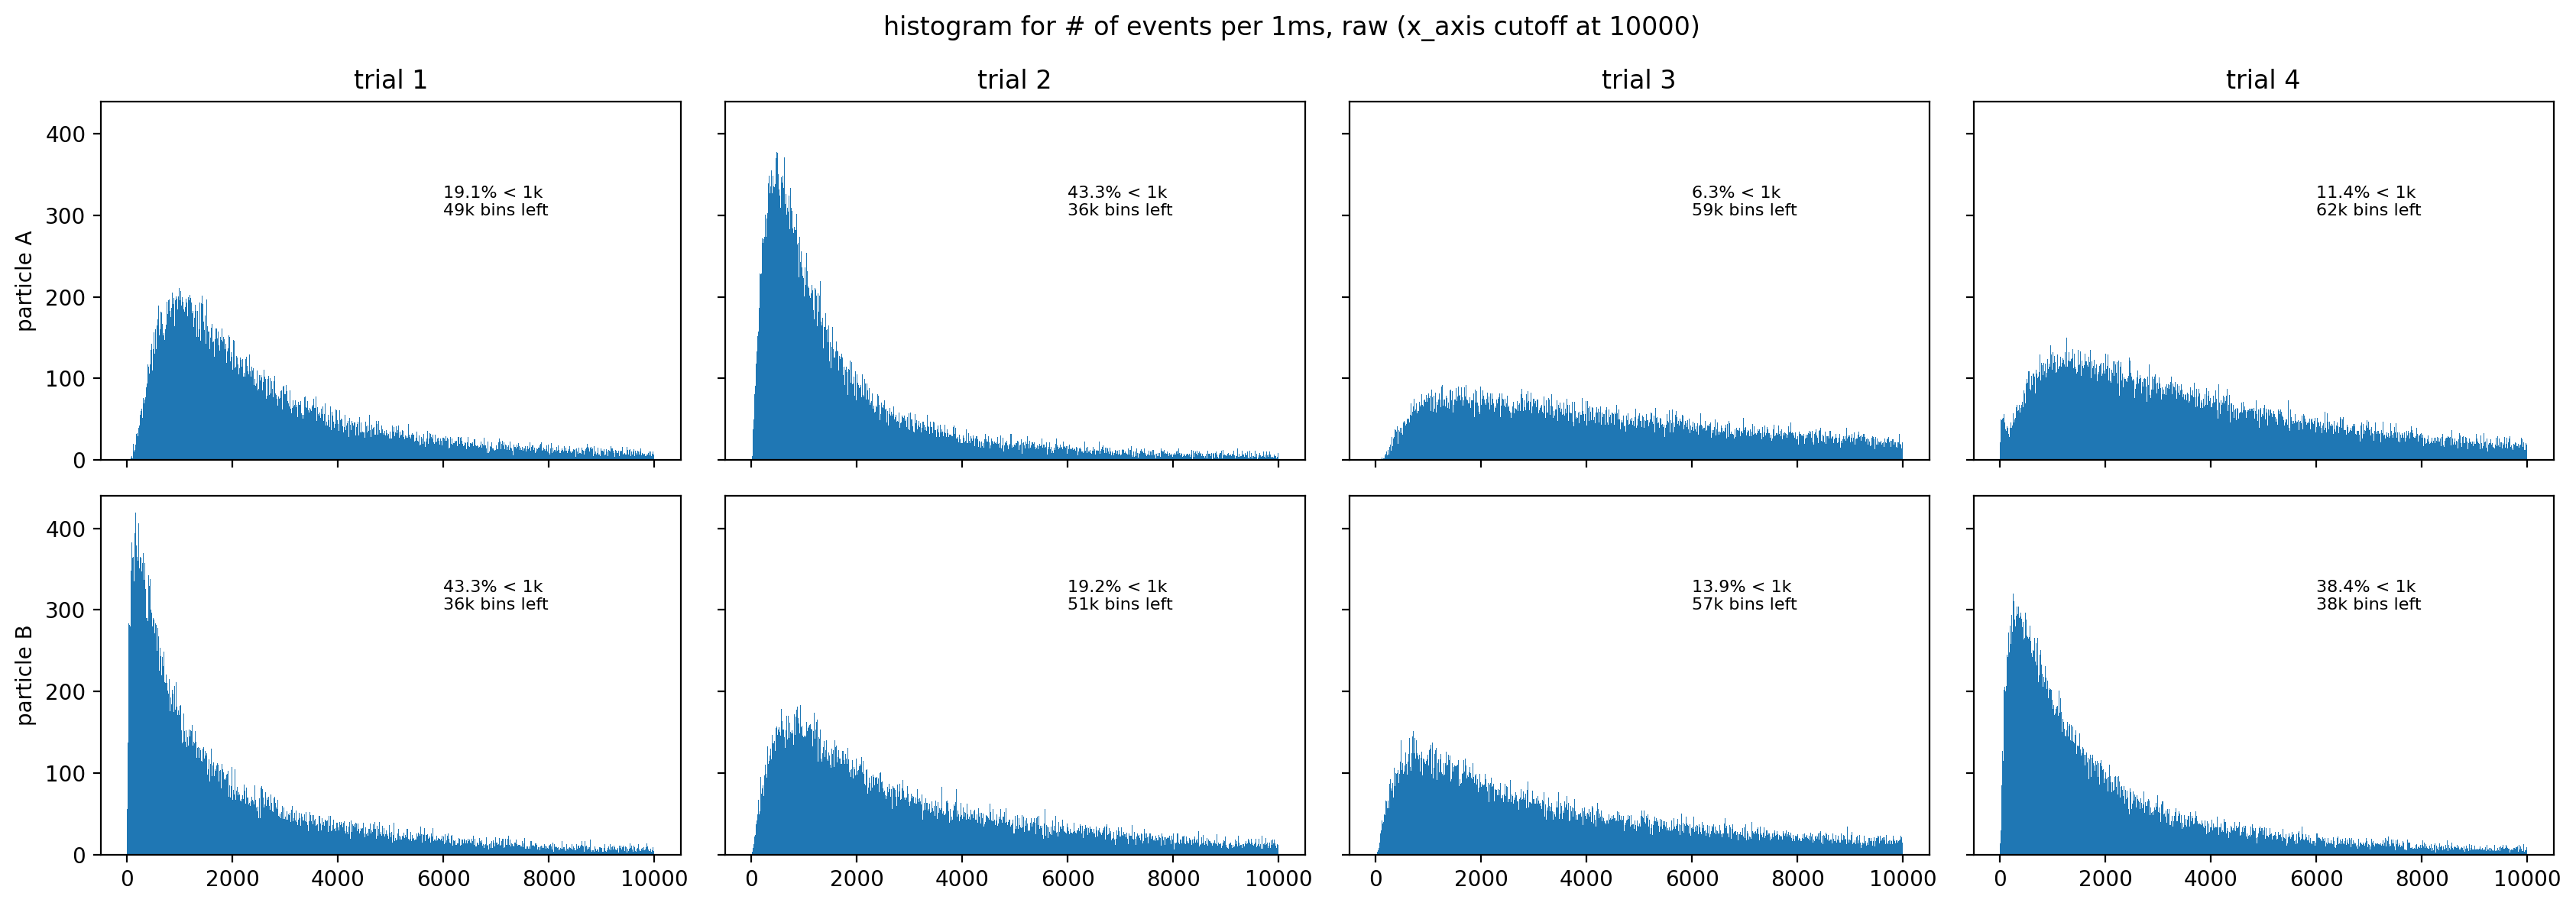

In [45]:
histogram_n_events(data='bin', comp=False, dt=1, max_x=10_000, n_bins=1_000, text_xy=(6000,300))

49,425 time bins with > 1k events (80.9% of total: 61,116)
3,115 events, 7,683 events, 2,930 events, 1,049 events
2,863 events, 2,725 events, 3,417 events, 1,944 events
1,224 events, 2,657 events, 11,305 events, 1,114 events
4,560 events, 9,635 events, 2,026 events, 3,539 events


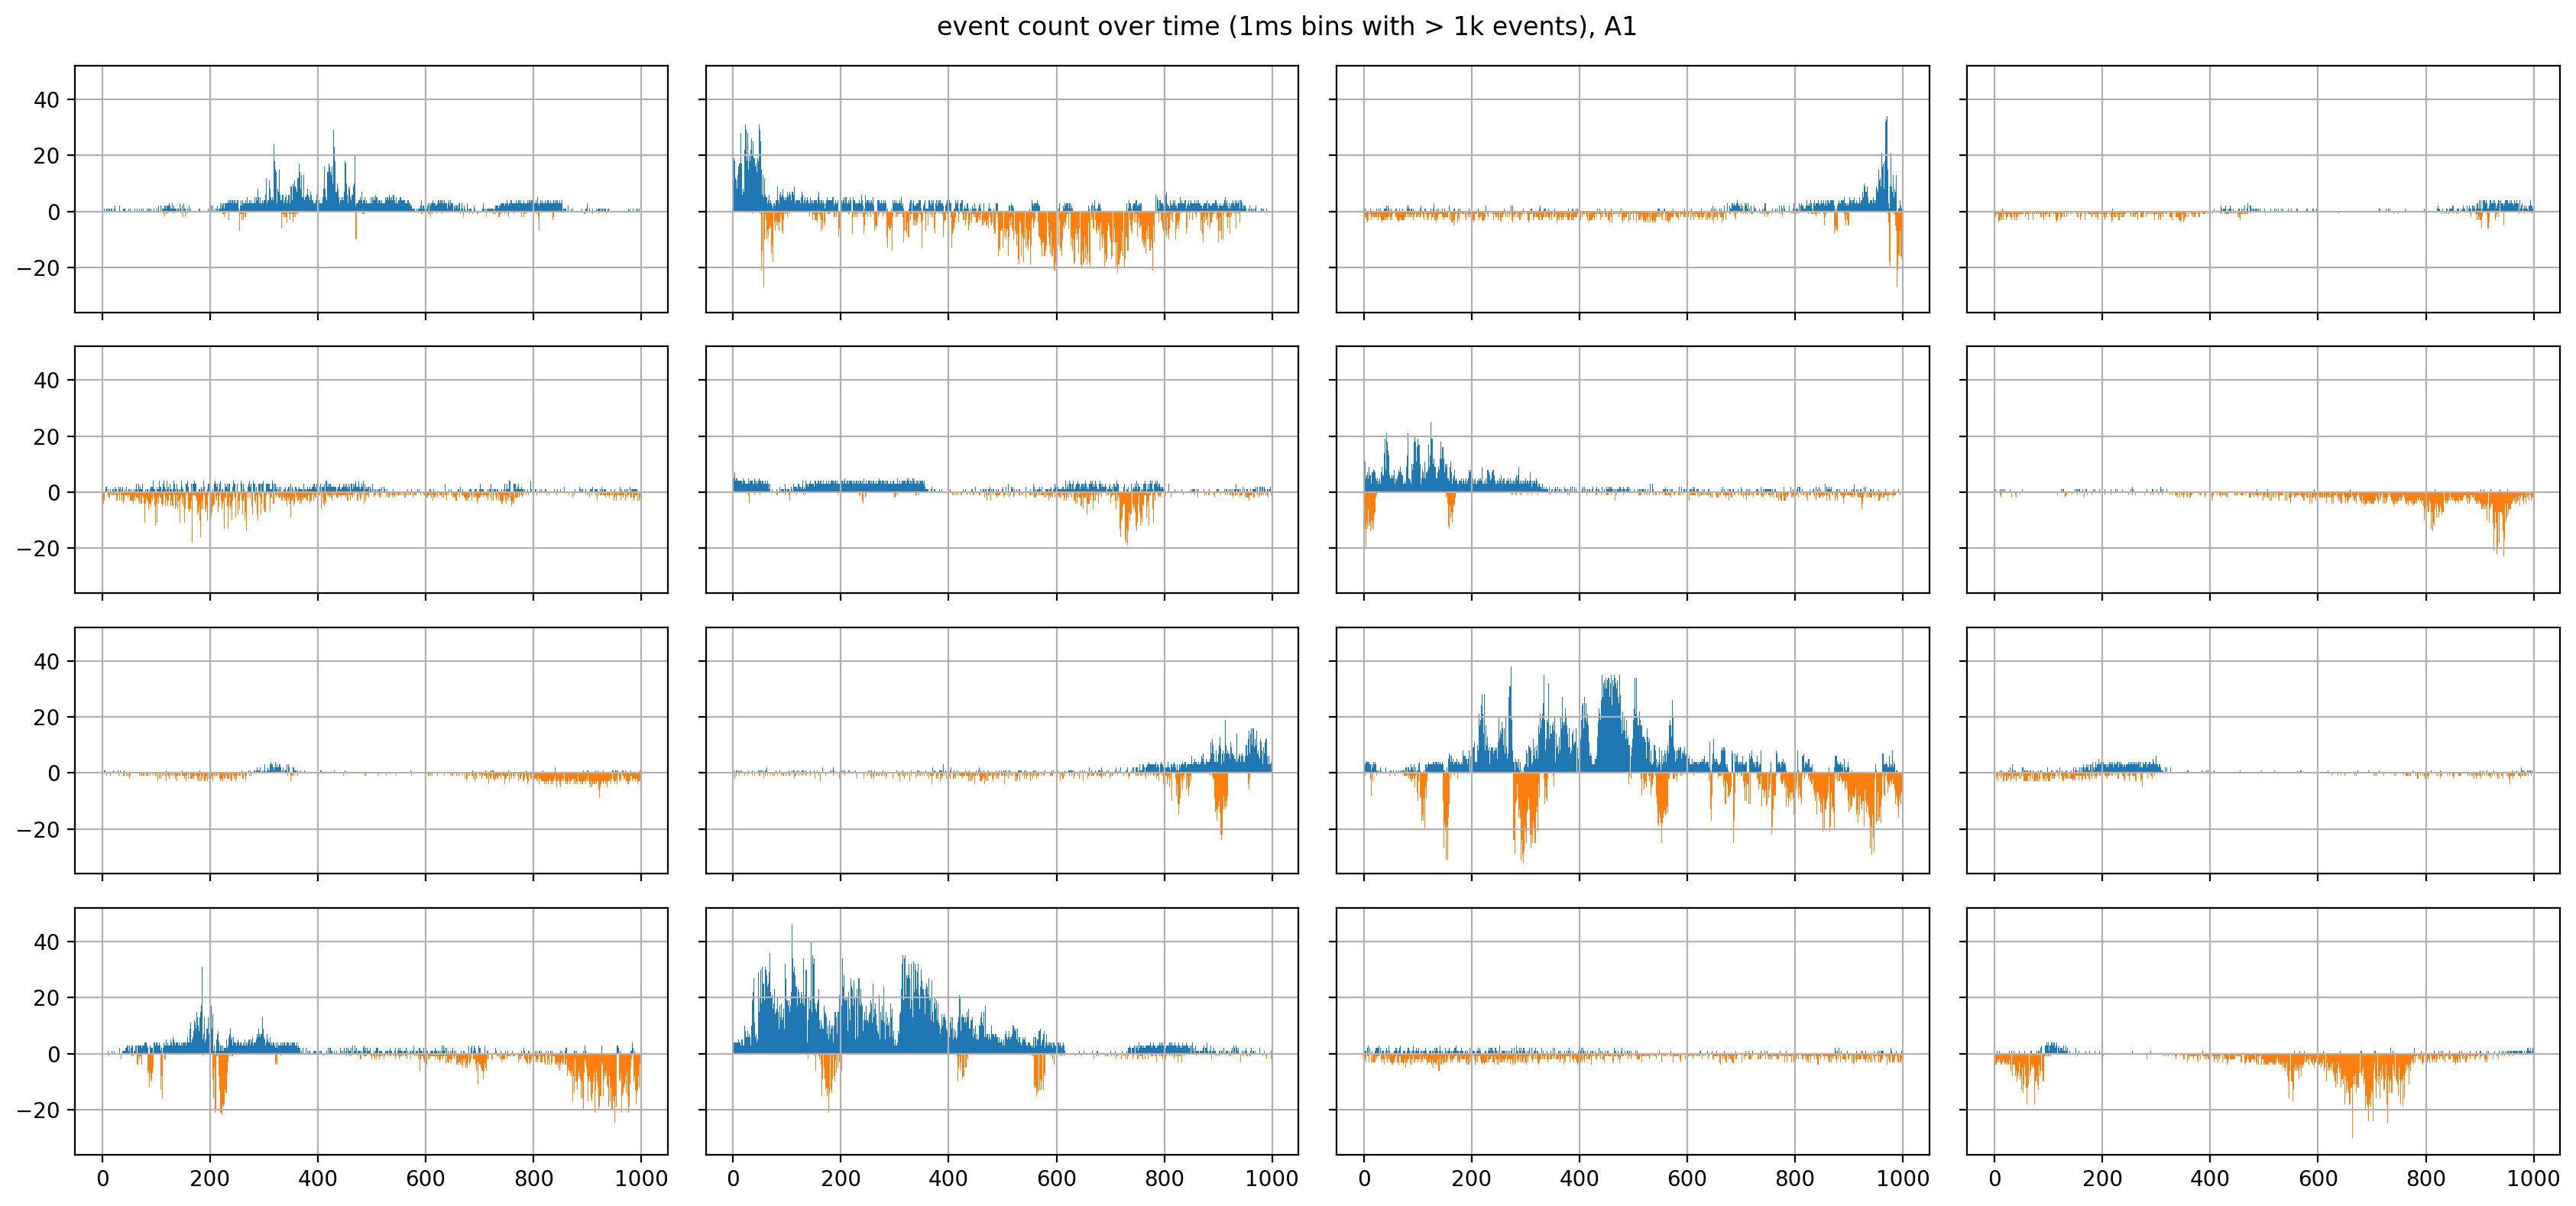

In [46]:
plot_samples('bin', '', 1, fn='A1', nrows=4, ncols=4)

## quat data

### quat compressed 10ms

particle A: removed 12k (49.9%), left 12k
particle B: removed 12k (51.0%), left 11k
particle C: removed 12k (52.7%), left 11k
particle D: removed 12k (49.1%), left 12k


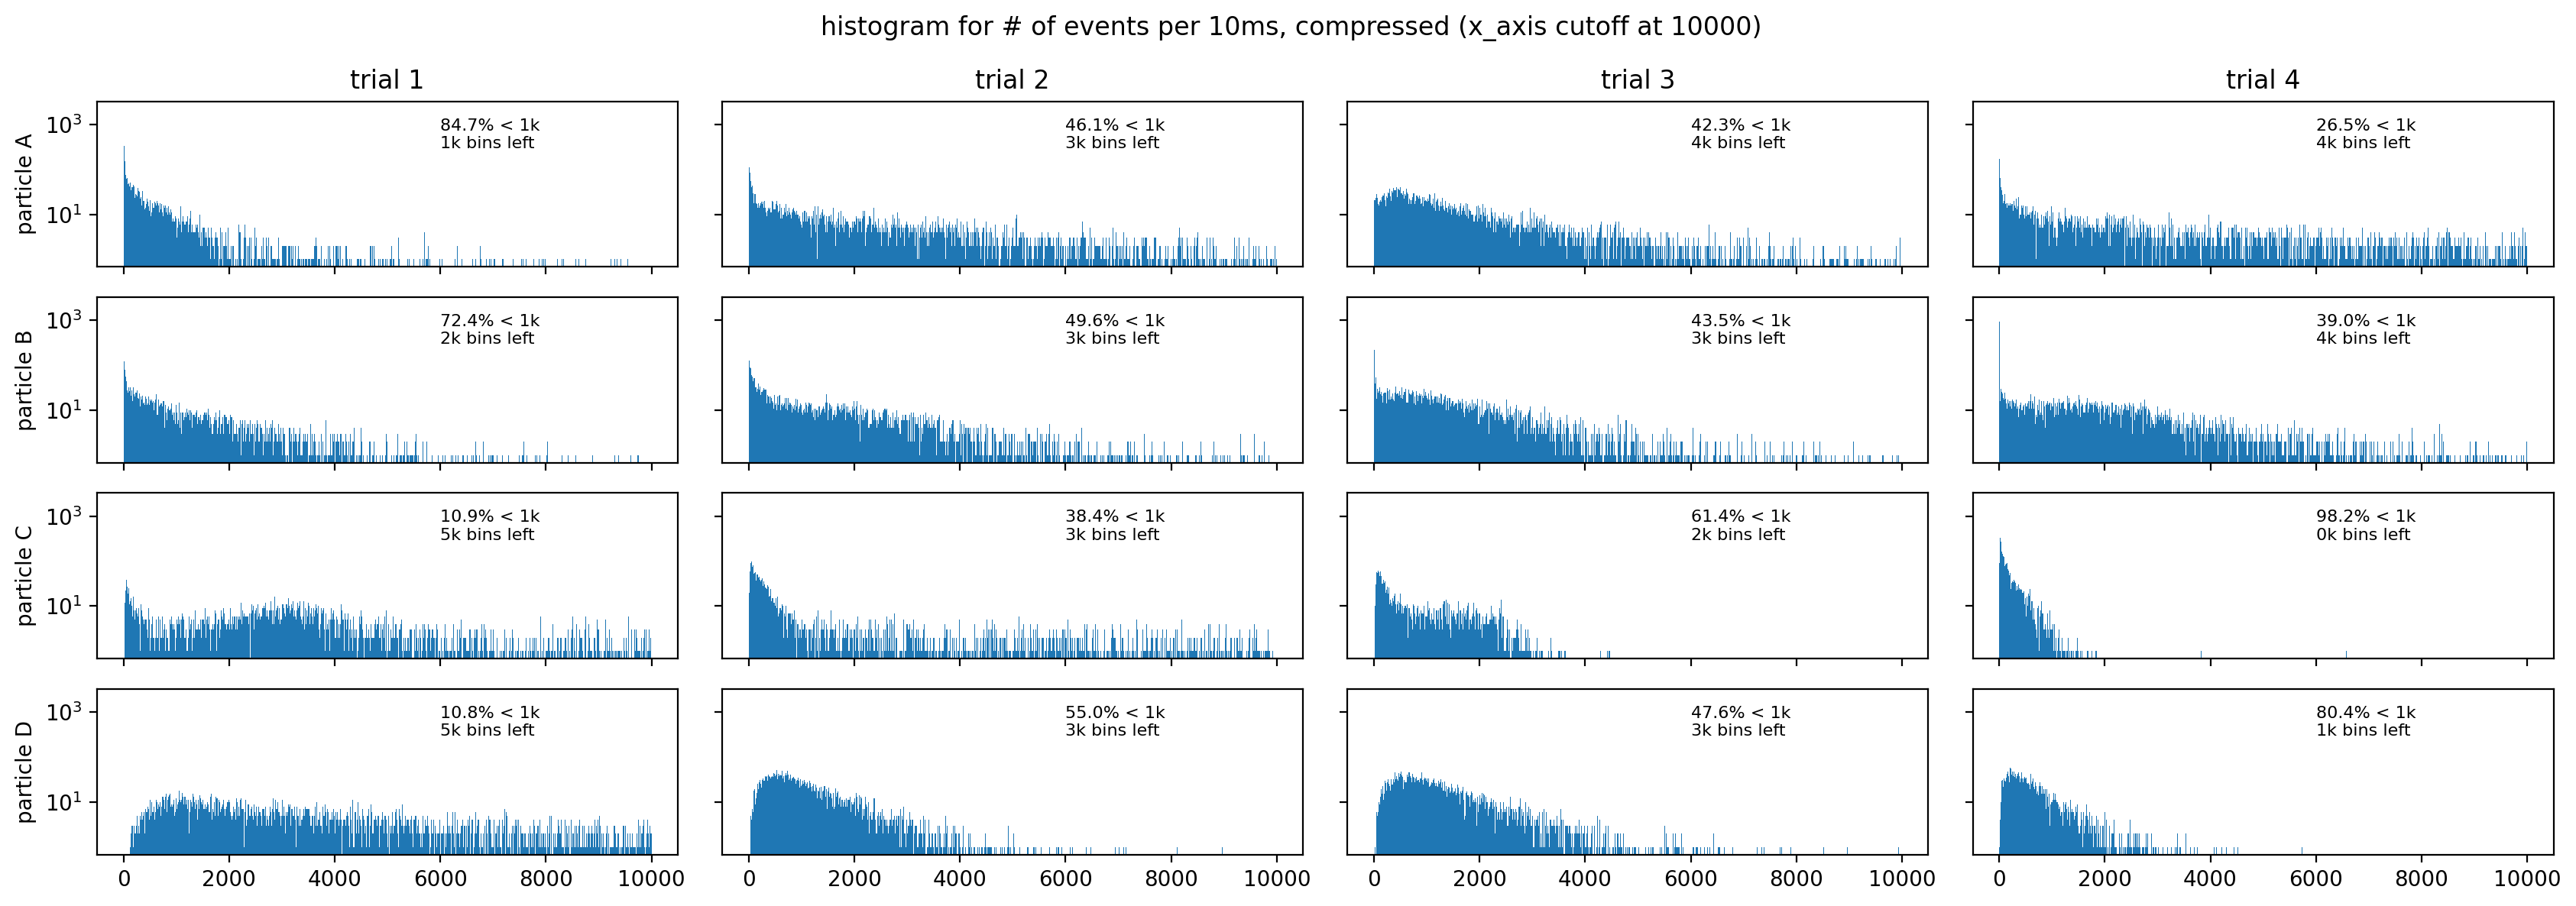

In [47]:
histogram_n_events(data='quat', comp=True, dt=10, max_x=10_000, n_bins=1_000, text_xy=(6000,300), yscale='log')

899 time bins with > 1k events (15.2% of total: 5,896)
5,068 events, 1,325 events, 2,086 events, 1,680 events
1,109 events, 2,318 events, 2,516 events, 1,337 events
3,642 events, 3,189 events, 1,763 events, 1,375 events
2,181 events, 4,569 events, 1,203 events, 1,835 events


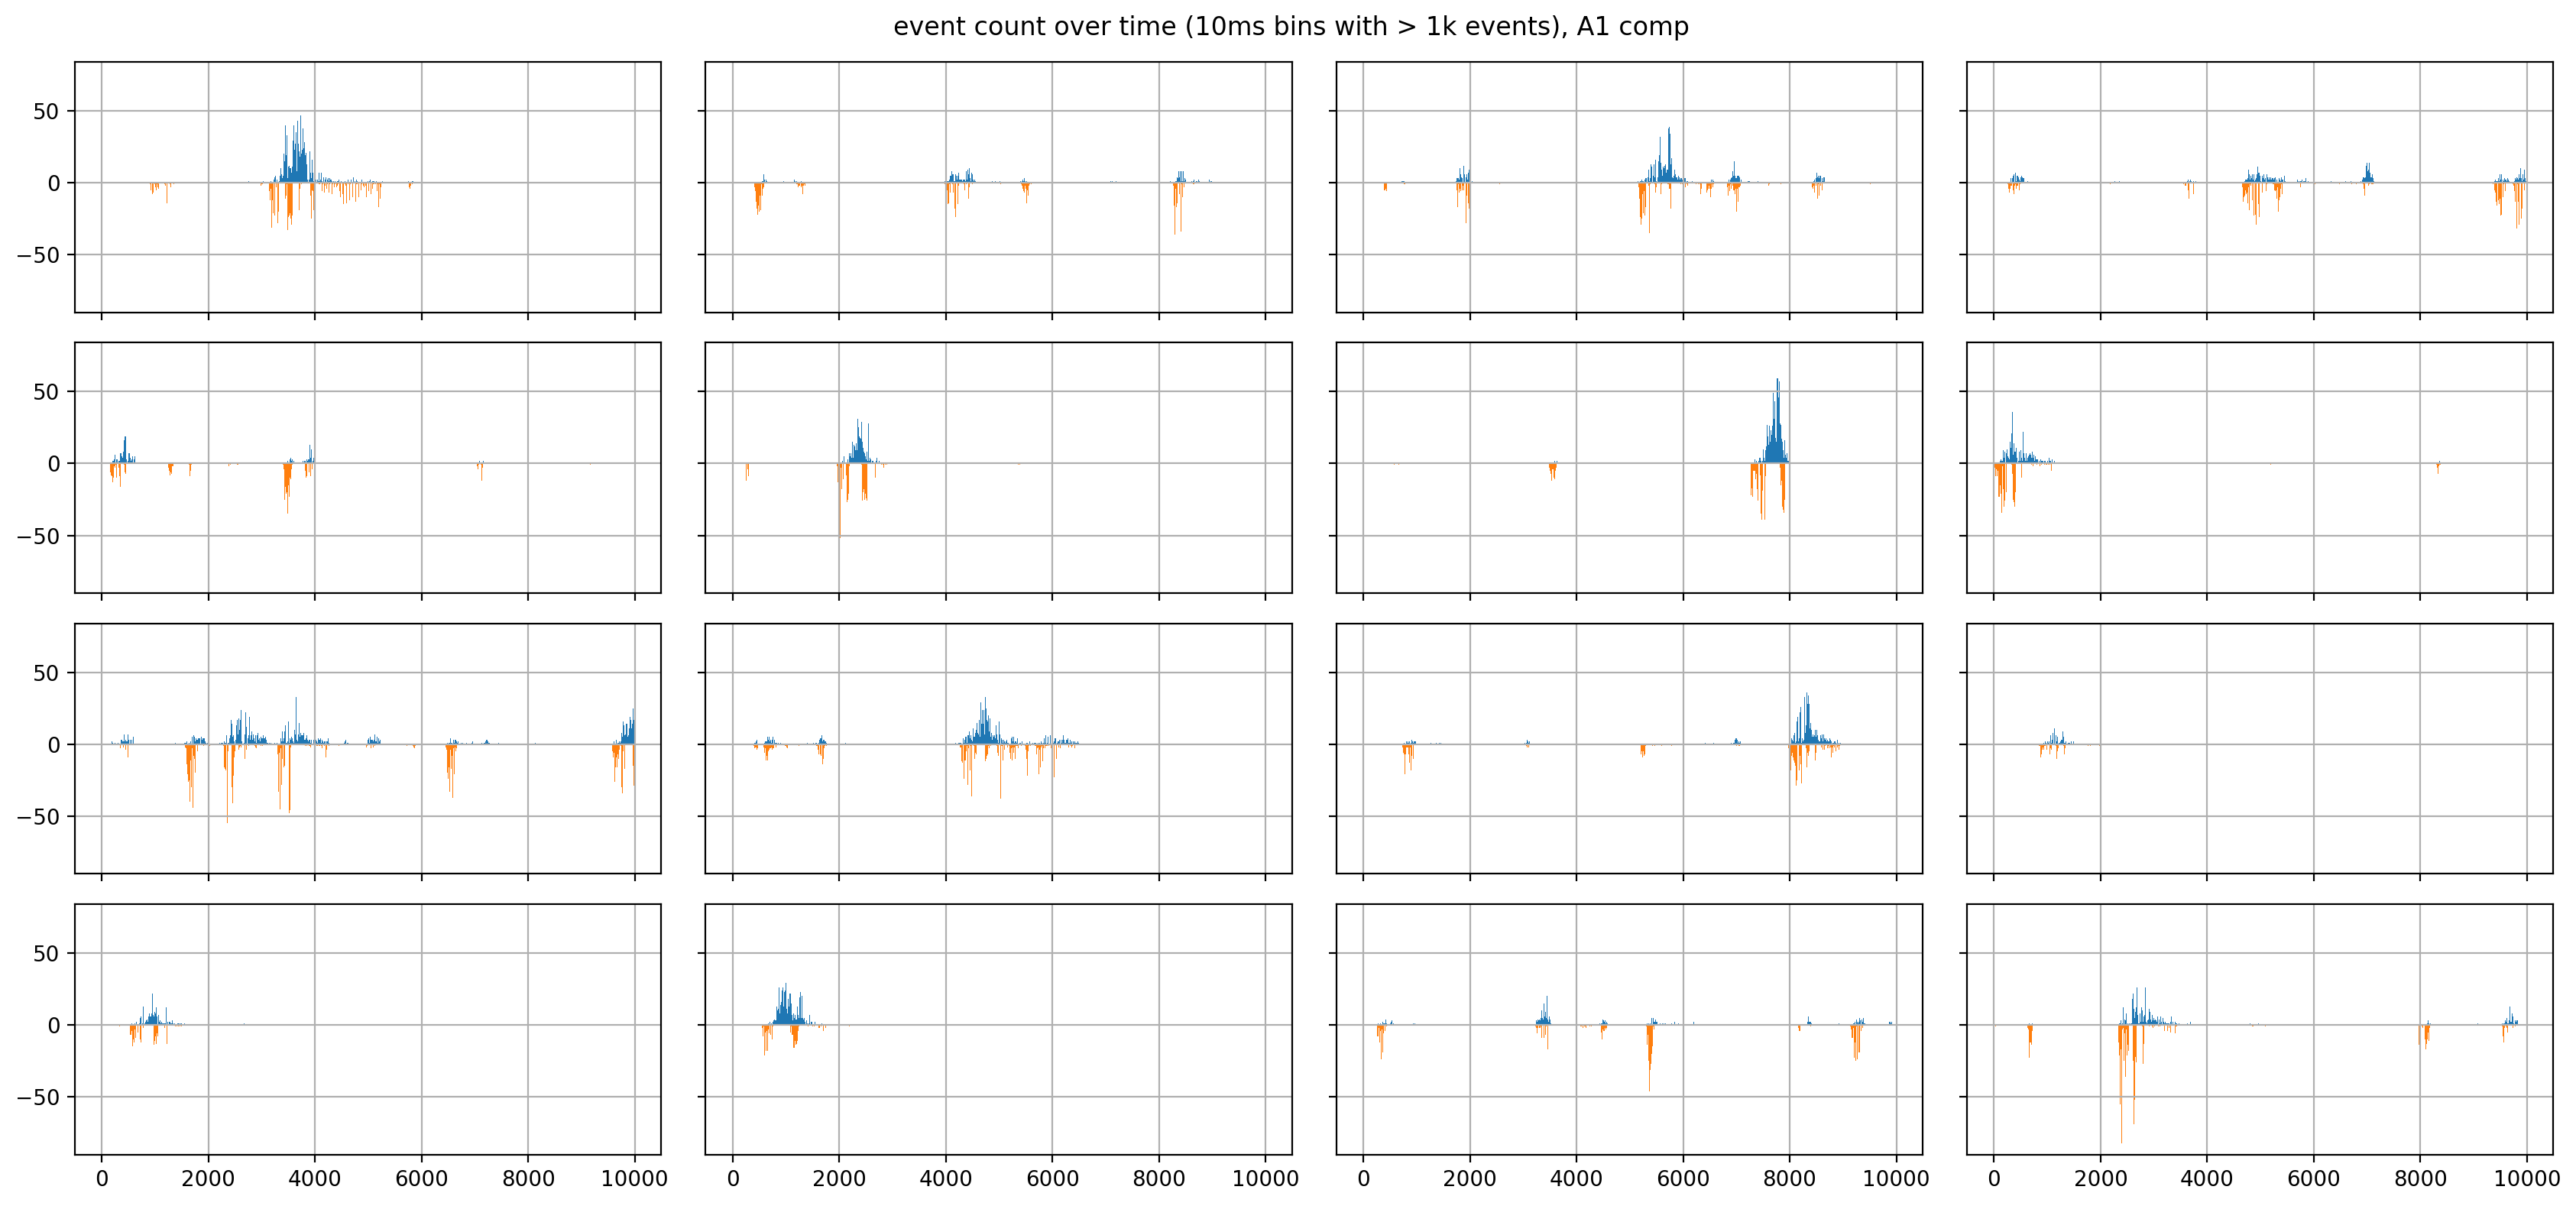

In [48]:
plot_samples('quat', 'comp', 10, fn='A1', nrows=4, ncols=4)

### quat compressed 1ms

particle A: removed 215k (91.3%), left 20k
particle B: removed 222k (95.7%), left 10k
particle C: removed 189k (81.7%), left 42k
particle D: removed 224k (94.4%), left 13k


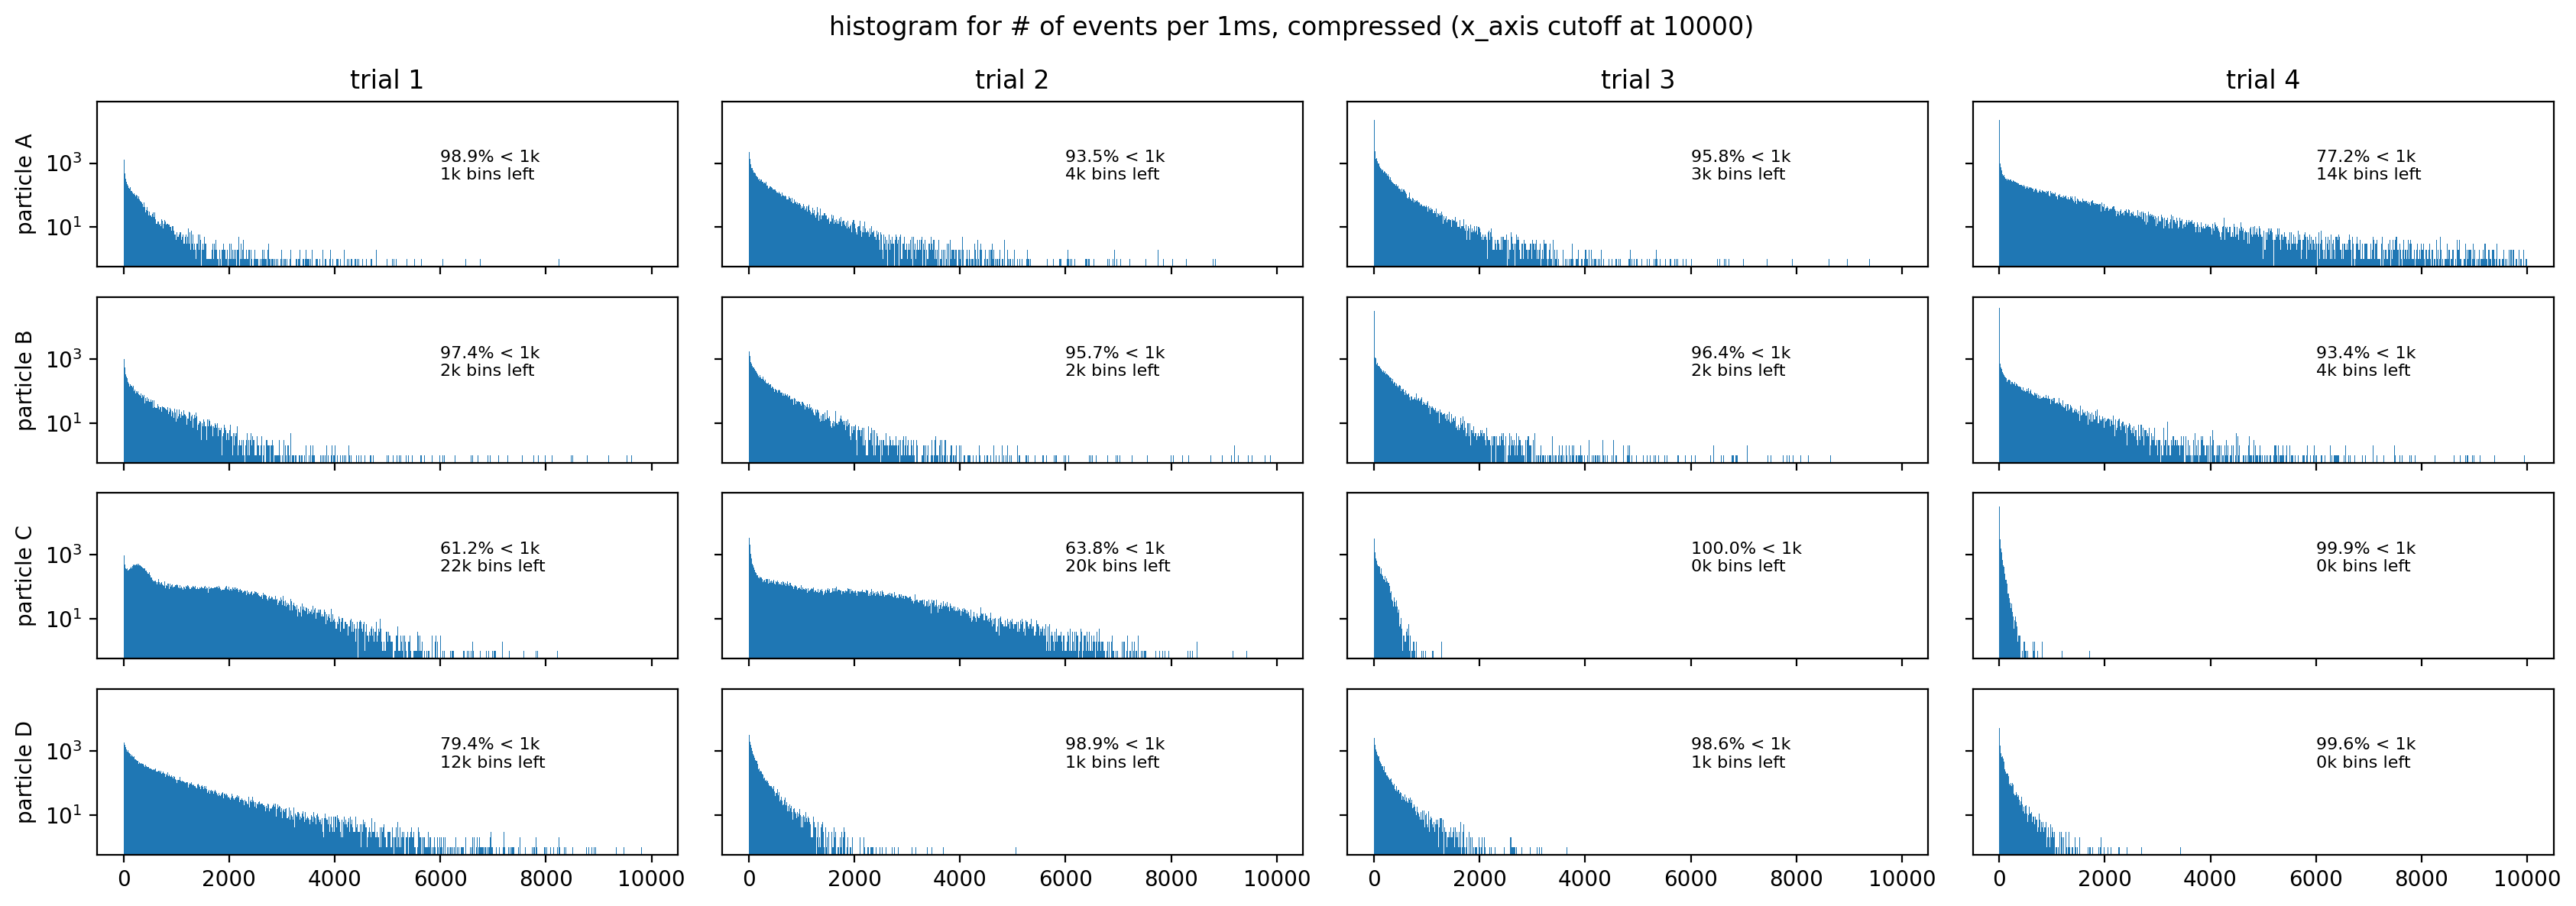

In [49]:
histogram_n_events(data='quat', comp=True, dt=1, max_x=10_000, n_bins=1_000, text_xy=(6000,300), yscale='log')

655 time bins with > 1k events (1.1% of total: 58,955)
1,098 events, 1,786 events, 1,674 events, 2,056 events
1,292 events, 4,550 events, 1,235 events, 1,129 events
3,452 events, 1,866 events, 3,488 events, 1,009 events
3,859 events, 1,408 events, 1,529 events, 1,351 events


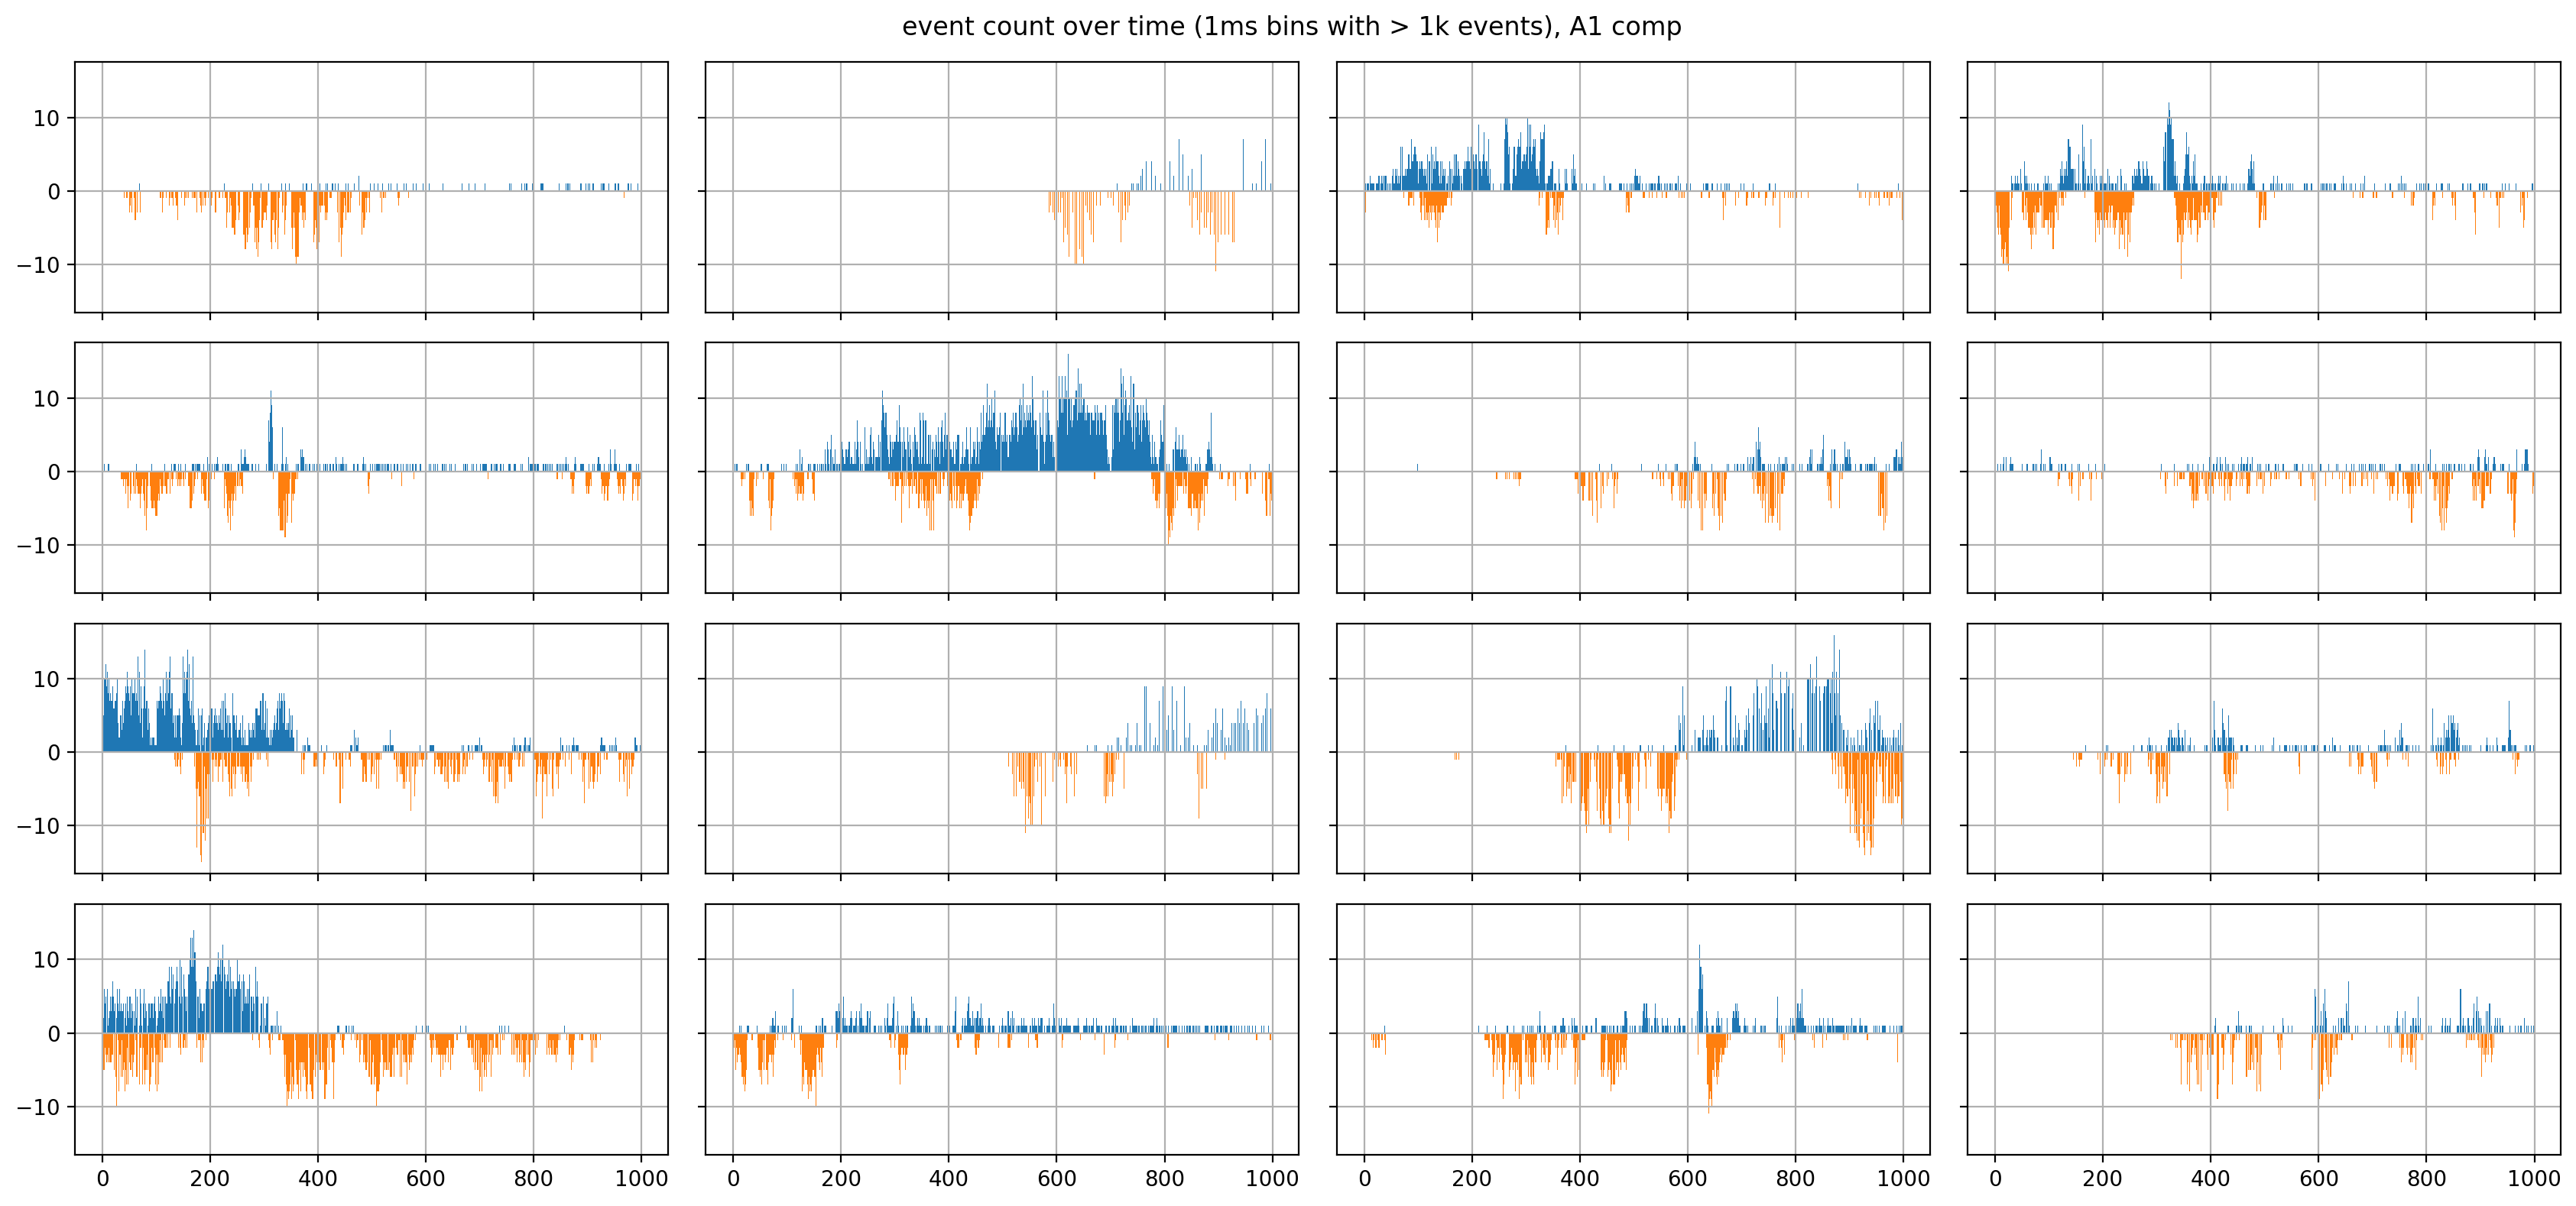

In [50]:
plot_samples('quat', 'comp', 1, fn='A1', nrows=4, ncols=4)